In [22]:
path_full_summarized_table = "../results/2023-05-24/00_processed/main/aurocs.tsv.gz"

path_config_viz = "../config/visualization.yaml"
path_output_dir = "./input_modalities.pysster_input_length/"
export = True


# Forewords

On the 2023-01-20 Marc trained a new set of models for Pysster, using input size of 101b in place of 400b, to explore whether the higher-performance observed for Pysster could be driven in part by this parameter.

This notebook is dedicated to comparing the performance of the "regular" Pysster models with input size = 400b and the performance from the modified Pysster models with input size reduced to 101b.


# Imports and definitions

In [ ]:
import os
import sys
from pathlib import Path

import pandas as pd
import polars as pl
import numpy as np
import yaml


path = "../code/"
if not str(path) in sys.path:
    sys.path.insert(0, str(path))

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from plotting_config import *

%run "../code/plotting_config.py"
%run "../code/figure_layouts.py"

/home/l10n/projects/hzm/Benchmark-RBP/analyses/code/figure_layouts.py:99: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


# Set-up

In [23]:
if export:
    if not Path(path_output_dir).exists():
        Path(path_output_dir).mkdir(parents=True, exist_ok=True)

# Load

## Data

In [5]:
full_summarized_table = pd.read_csv(
    path_full_summarized_table, sep="\t", header=0, index_col=None
)


## Config

In [4]:
with open(path_config_viz, "r") as in_f:
    config_viz = yaml.load(in_f, Loader=yaml.SafeLoader)


DATASETS_COLORS = config_viz["datasets"]["colors"]
DATASETS_dotshape = config_viz["datasets"]["shape"]
arch_colors = config_viz["methods"]["colors"]

# Prepare tables

In [6]:
# This table is used for the boxplot per dataset and the scatterplot.
tmp_pysster_size = (
    full_summarized_table.loc[lambda df: df["arch"].str.startswith("Pysster"), :]
    .pivot_table(
        columns="arch",
        index=["dataset", "RBP_dataset", "model_negativeset"],
        values="auroc",
    )
    .reset_index()
)

tmp_pysster_size["delta"] = (
    tmp_pysster_size["Pysster-101"] - tmp_pysster_size["Pysster"]
)


In [7]:
tmp_pysster_prismnet_n1 = full_summarized_table.loc[
    lambda df: (df["model_negativeset"] == "negative-1")
    & (df["arch"].isin(["Pysster", "Pysster-101", "PRISMNet"])),
    :,
]

tmp_pysster_prismnet_n2 = full_summarized_table.loc[
    lambda df: (df["model_negativeset"] == "negative-2")
    & (df["arch"].isin(["Pysster", "Pysster-101", "PRISMNet"])),
    :,
]


# Plot

## Scatterplot auROCs pysster101 = f(pysster)

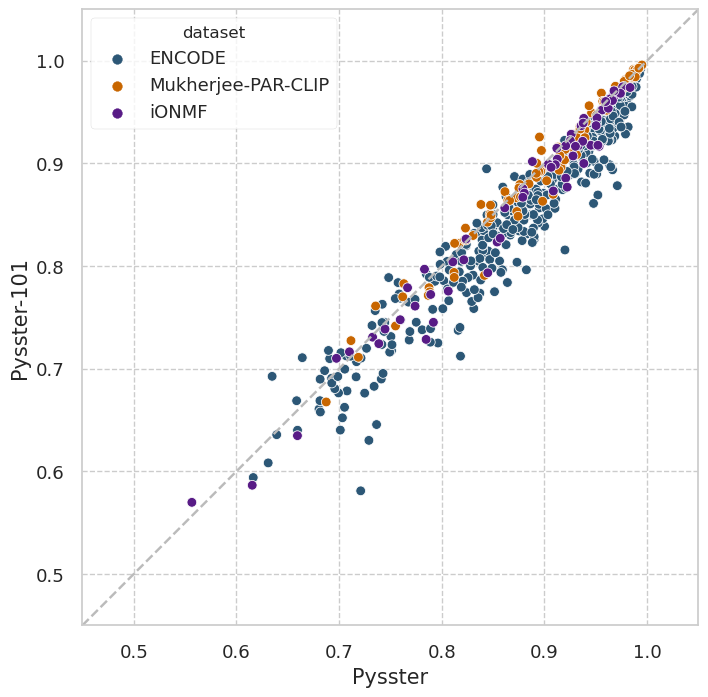

In [8]:
# Scatterplot auroc p101 = auroc p
fig = plt.figure(
    figsize=(
        8,
        8,
    )
)
ax1 = fig.add_subplot(1, 1, 1)

sns.scatterplot(
    data=tmp_pysster_size,
    x="Pysster",
    y="Pysster-101",
    hue="dataset",
    palette=DATASETS_COLORS,
    # style='dataset',
    # marker=DATASETS_dotshape,
    ax=ax1,
)

ax1.set_aspect("equal")

ax1.set_xlim(0.45, 1.05)
ax1.set_ylim(0.45, 1.05)

# Diagonal
ax1.plot((0.45, 1.05), (0.45, 1.05), linestyle="--", color="#BBBBBB")

plt.show()


## Boxplot delta auROC per dataset

In [14]:
def plot_deltaauroc_pysster(tmp_pysster_size, ax=None):
    if ax is None:
        fig = plt.figure(figsize=(3, 8))
        ax1 = fig.add_subplot(1, 1, 1)
    else:
        ax1 = ax

    ax1.axhline(
        y=tmp_pysster_size["delta"].mean(),
        linestyle="--",
        linewidth=4,
        color="#C84244",
        label="Average",
    )

    ax1.text(
        x=-0.55,
        y=tmp_pysster_size["delta"].mean(),
        s=f"{tmp_pysster_size['delta'].mean():.2}",
        color="#C84244",
        fontsize=12,
        fontweight="bold",
        ha="right",
    )

    ax1.set_ylim(
        -tmp_pysster_size["delta"].abs().max() * 1.1,
        tmp_pysster_size["delta"].abs().max() * 1.1,
    )

    for DATASET, tmp_pysster_dataset in tmp_pysster_size.groupby("dataset"):
        sns.stripplot(
            data=tmp_pysster_dataset,
            x="dataset",
            y="delta",
            hue="dataset",
            palette=DATASETS_COLORS,
            # style='dataset',
            marker=DATASETS_dotshape[DATASET],
            edgecolor="#FFFFFF",
            linewidth=1,
            size=10,
            zorder=0,
            alpha=0.5,
            ax=ax1,
        )

    # Add boxplot without face colors.
    BOXPLOT_PROPS = {
        "boxprops": {"facecolor": "none", "edgecolor": "#444444"},
        "medianprops": {"color": "#444444"},
        "whiskerprops": {"color": "#444444"},
        "capprops": {"color": "#444444"},
        "meanprops": {
            "marker": "o",
            "markerfacecolor": "#AF2121",
            "markeredgecolor": "#AF2121",
            "markersize": 8,
        },
    }

    sns.boxplot(
        data=tmp_pysster_size,
        x="dataset",
        y="delta",
        showfliers=False,
        showmeans=True,
        linewidth=2,
        ax=ax1,
        zorder=10,
        **BOXPLOT_PROPS,
    )

    ax1.legend_.set_title("")
    ax1.set_xticklabels("")
    ax1.set_xlabel("Datasets", fontsize=14)
    ax1.set_ylabel("Delta auROC (Pysster - Pysster-101)", fontsize=14)

    plt.tight_layout()

    return ax1


Saving


<Figure size 775.974x775.974 with 0 Axes>

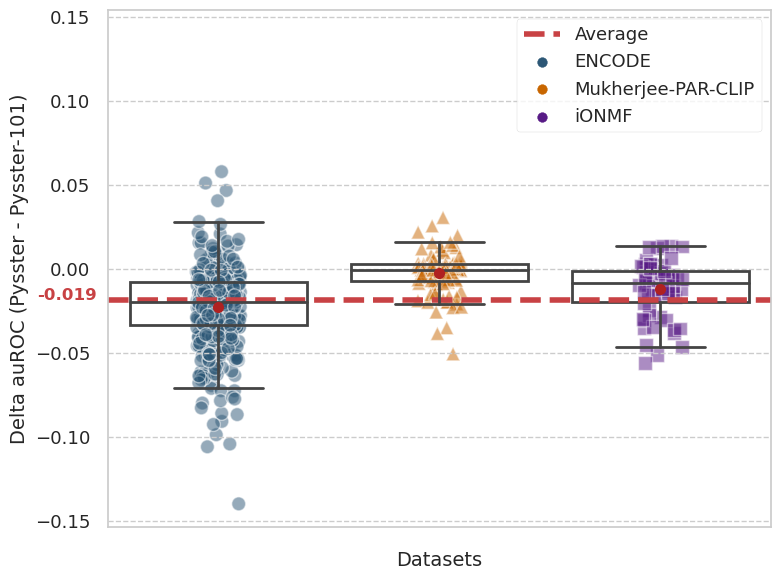

In [18]:


figure_name = "delta_aurocs_pysster_pysster101"

if export:
    savefig_file = str(Path(path_output_dir) / f"{figure_name}.{{EXT}}")
else:
    savefig_file = None

panel_name = "c"
fig = plt.figure(figsize=[v * 5 for v in FIG3_PANEL_SIZES["i"]])
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(1, 1, 1)

plot_deltaauroc_pysster(tmp_pysster_size, ax=ax1)

if savefig_file:
    print("Saving")
    my_savefig(savefig_file, ext_list=["png", "svg", "pdf"])

plt.show()


## Paper

### Full plot

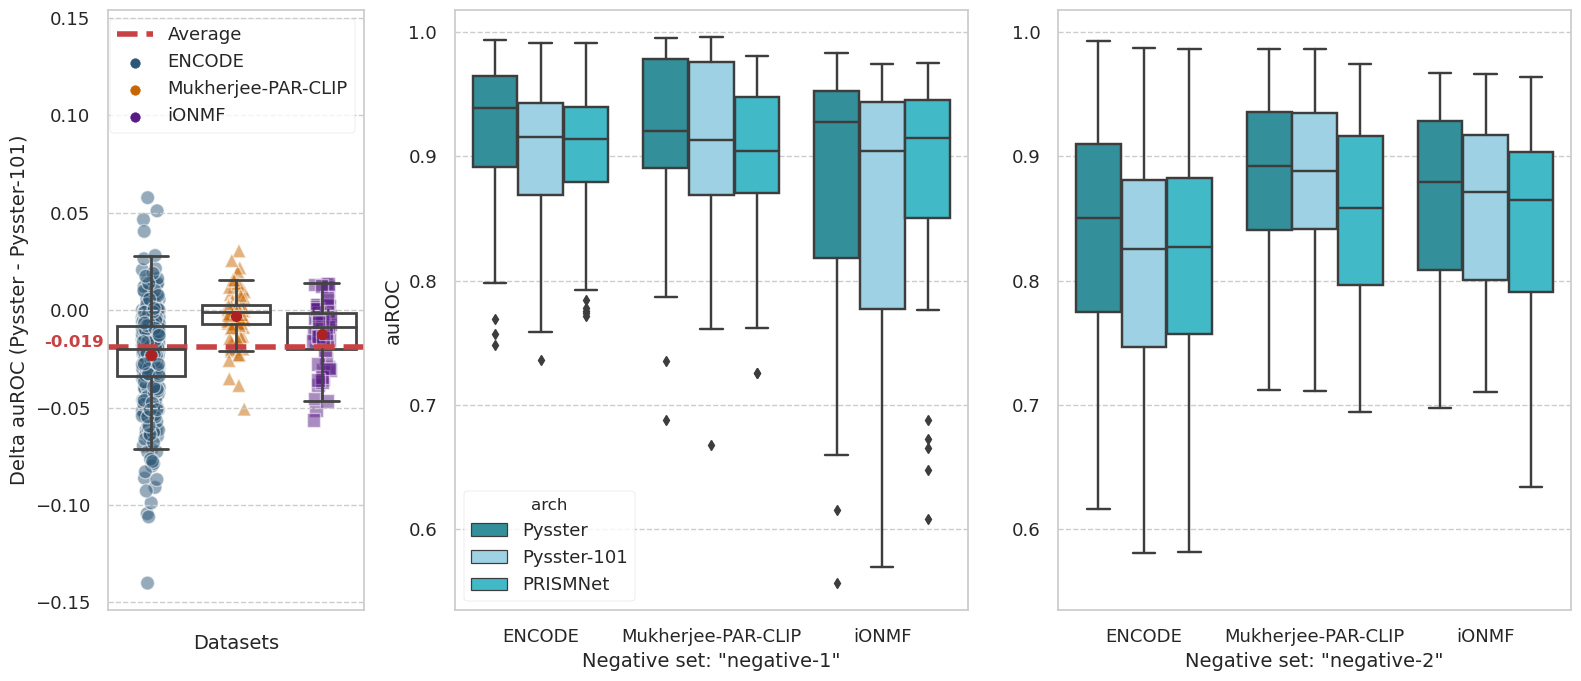

In [19]:
fig = plt.figure(figsize=(16, 7))

gs = GridSpec(1, 3, width_ratios=[1, 2, 2], height_ratios=[1])

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2], sharey=ax2)


plot_deltaauroc_pysster(tmp_pysster_size, ax=ax1)


sns.boxplot(
    data=tmp_pysster_prismnet_n1,
    y="auroc",
    x="dataset",
    hue="arch",
    palette=arch_colors,
    hue_order=["Pysster", "Pysster-101", "PRISMNet"],
    ax=ax2,
)

ax2.set_ylabel("auROC", fontsize=14)
ax2.set_xlabel('Negative set: "negative-1"', fontsize=14)


sns.boxplot(
    data=tmp_pysster_prismnet_n2,
    y="auroc",
    x="dataset",
    hue="arch",
    palette=arch_colors,
    hue_order=["Pysster", "Pysster-101", "PRISMNet"],
    ax=ax3,
)

ax3.set_ylabel("")
ax3.legend_.remove()

ax3.set_xlabel('Negative set: "negative-2"', fontsize=14)

plt.tight_layout()


plt.show()


We end up only retaining the boxplots ; here below plotted separately.

negative-1 b input_modalities.pysster_input_length/fig3_panel_b.{EXT}


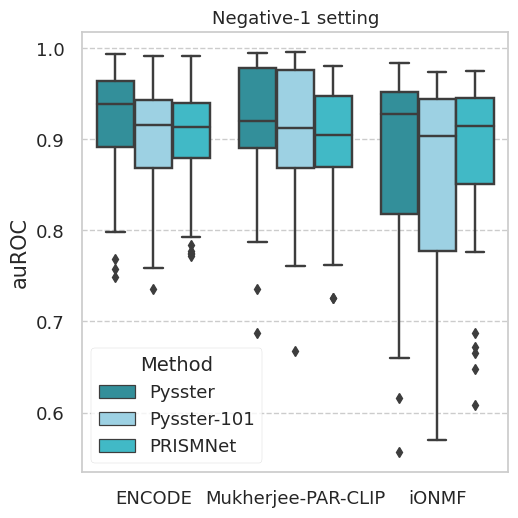

negative-2 c input_modalities.pysster_input_length/fig3_panel_c.{EXT}


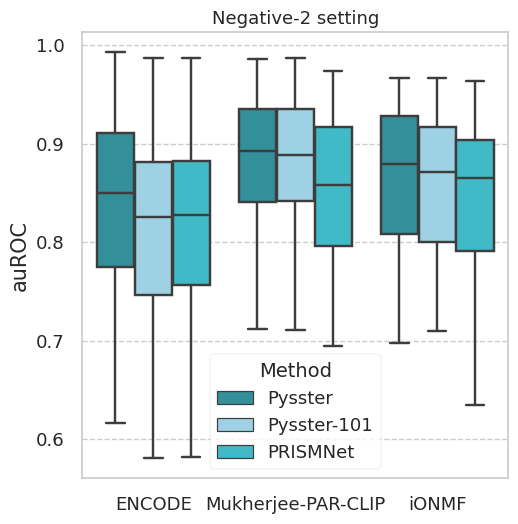

In [24]:

groups = zip(
    ["negative-1", "negative-2"],
    ["b", "c"],
    [tmp_pysster_prismnet_n1, tmp_pysster_prismnet_n2],
)

for NEGATIVE, panel_name, tmp_table in groups:
    
    figure_name = f"boxplot_aurocs_pysster_pysster101_prismnet.{NEGATIVE}"

    if export:
        savefig_file = str(Path(path_output_dir) / f"fig3_panel_{panel_name}.{{EXT}}")
    else:
        savefig_file = None

    print(NEGATIVE, panel_name, savefig_file)

    fig = plt.figure(figsize=[v * 3.5 for v in FIG3_PANEL_SIZES[panel_name]])
    ax1 = fig.add_subplot(1, 1, 1)

    sns.boxplot(
        data=tmp_table,
        y="auroc",
        x="dataset",
        hue="arch",
        palette=arch_colors,
        hue_order=["Pysster", "Pysster-101", "PRISMNet"],
        ax=ax1,
    )

    ax1.set_xlabel("")
    ax1.legend_.set_title("Method")
    plt.setp(ax1.legend_.get_title(), fontsize=14)

    ax1.set_ylabel("auROC")
    ax1.set_title(f"{NEGATIVE.capitalize()} setting")

    fig.subplots_adjust(left=0.10)

    plt.tight_layout()

    if export:
        my_savefig(savefig_file, ext_list=["png", "svg", "pdf"])

    plt.show()
